![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---


# On-Policy Control (Sarsa) with Linear Value Function Approximation
(*Code adapted from: https://github.com/SamKirkiles/mountain-car-SARSA-AC/blob/master/mountain_car.py*)

## Imports

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
import sklearn.pipeline
import sklearn.preprocessing
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Mountain Car Environment

<img src="./img/mountain_car.gif" alt="Mountain Car" width="500">


The agent (a car) is started at the bottom of a valley. For any given
state the agent may choose to accelerate to the left, right or cease
any acceleration.

    Source:
        The environment appeared first in Andrew Moore's PhD Thesis (1990).

    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07

    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right

        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.

    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5) on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.

    Starting State:
         The position of the car is assigned a uniform random value in [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.

    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200


In [2]:
env = gym.make('MountainCar-v0')

In [3]:
num_episodes = 200
num_episodes_render = 10
discount_factor = 1.0
alpha = 0.01
nA = env.action_space.n

# Parameter vector define number of parameters per action based on featurizer size
w = np.zeros((nA, 400))

# Plots
plt_actions = np.zeros(nA)
episode_rewards = np.zeros(num_episodes)

## Features
Here: Radial Basis Functions. For more information check Sutton & Barto Chap. 9.5.5

<img src="./img/radial_basis_function.png" alt="Radial Basis Function" width="350">

In [4]:
# Get satistics over observation space samples for normalization
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Create radial basis function sampler to convert states to features for nonlinear function approx
featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])
# Fit featurizer to our scaled inputs
featurizer.fit(scaler.transform(observation_examples))


# Normalize and turn into feature
def featurize_state_rbf(state):
    # Transform data
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized

## Episodic Semi-gradient Sarsa Algorithm with Linear Function Approximation
Sutton & Barto page 244

In [5]:
def Q(state, action, w):
    # Our linear model takes the state and gives us the action value function for all possible actions
    # (accelerate to the left / don't accelerate / accelerate to the right) so to evaluate the q-function
    # only use the weights that are corresponding to the action we take.
    value = state.dot(w[action])
    return value


# Epsilon greedy policy
def policy(state, weight, epsilon=0.1):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax([Q(state, a, w) for a in range(nA)])
    A[best_action] += (1.0 - epsilon)
    sample = np.random.choice(nA, p=A)
    return sample

In [6]:
for e in tqdm(range(num_episodes)):

    state = env.reset()
    state = featurize_state_rbf(state)

    while True:
        if np.mod(e, num_episodes_render) == 0:
            env.render()
        # Sample from policy
        action = policy(state, w)
        # Staistic for graphing
        plt_actions[action] += 1
        # Step environment and get next state and make it a feature
        next_state, reward, done, _ = env.step(action)
        next_state = featurize_state_rbf(next_state)

        # Figure out what our policy tells us to do for the next state
        next_action = policy(next_state, w)

        # Statistic for graphing
        episode_rewards[e] += reward

        # Figure out target and td error
        target = reward + discount_factor * Q(next_state, next_action, w)
        td_error = Q(state, action, w) - target

        # Update weights
        dw = (td_error).dot(state)
        w[action] -= alpha * dw

        if done:
            break
        # update our state
        state = next_state
        
env.close()

100%|████████████████████| 200/200 [02:05<00:00,  1.59it/s]


## Evaluate Run
Take a look at the return per episode the agent could achieve. <br>
Take a look at the Cost-to-go function ($-\max_a \hat{Q}(s, a, w)$) the agent learned.

In [7]:
def plot_cost_to_go_mountain_car(num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max([Q(featurize_state_rbf(_), a, w) for a in range(nA)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain Car Cost-to-Go Function")
    fig.colorbar(surf)
    plt.show()

In [8]:
def plot_training_result():
    plt.figure()
    plt.plot(np.arange(num_episodes), episode_rewards)
    plt.title('Training Result')
    plt.ylabel('Return')
    plt.xlabel('Episode')
    plt.show()

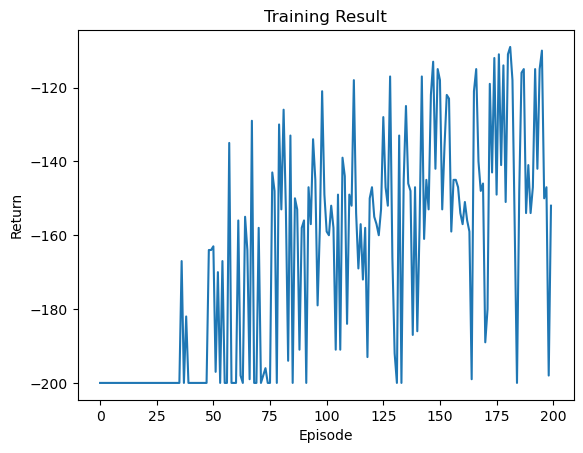

In [9]:
plot_training_result()

In [10]:
%matplotlib qt
plot_cost_to_go_mountain_car()